<a href="https://colab.research.google.com/github/Hsynyvz/-NLP-natural-language-processing-/blob/main/PytorchMulti_label_classification_using_transformers_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

We’ll need the Transformers library by Hugging Face and others 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.9 MB/s eta 0:00:00


In [ ]:
import transformers

from transformers import AutoTokenizer, AutoModel


import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



Using Colab GPU for Training

In [ ]:

# reference link https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=nSU7yERLP_66

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# **Data Exploration**

We’ll load dataset

In [ ]:
df = pd.read_excel("/content/MIMIC.xlsx")
df.head(5)

,sentence,code
0,pt transferred to [**hospital unit name 4**] c...,J80
1,chb d/t hypothyroidism--pt with recent hx of n...,E039
2,the patient is a 67-year-old female with a his...,I4891
3,"rca, htn, gerd, left knee replacement, bipolar...",F319
4,chronic obstructive pulmonary disease diabetes...,E119


In [ ]:
df.shape # getting the shape of dataframe 

(81027, 2)

We have about 81k examples. Let’s check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81027 entries, 0 to 81026
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  81027 non-null  object
 1   code      81027 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


no missing values in the sentenc and code! Do we have class imbalance?

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


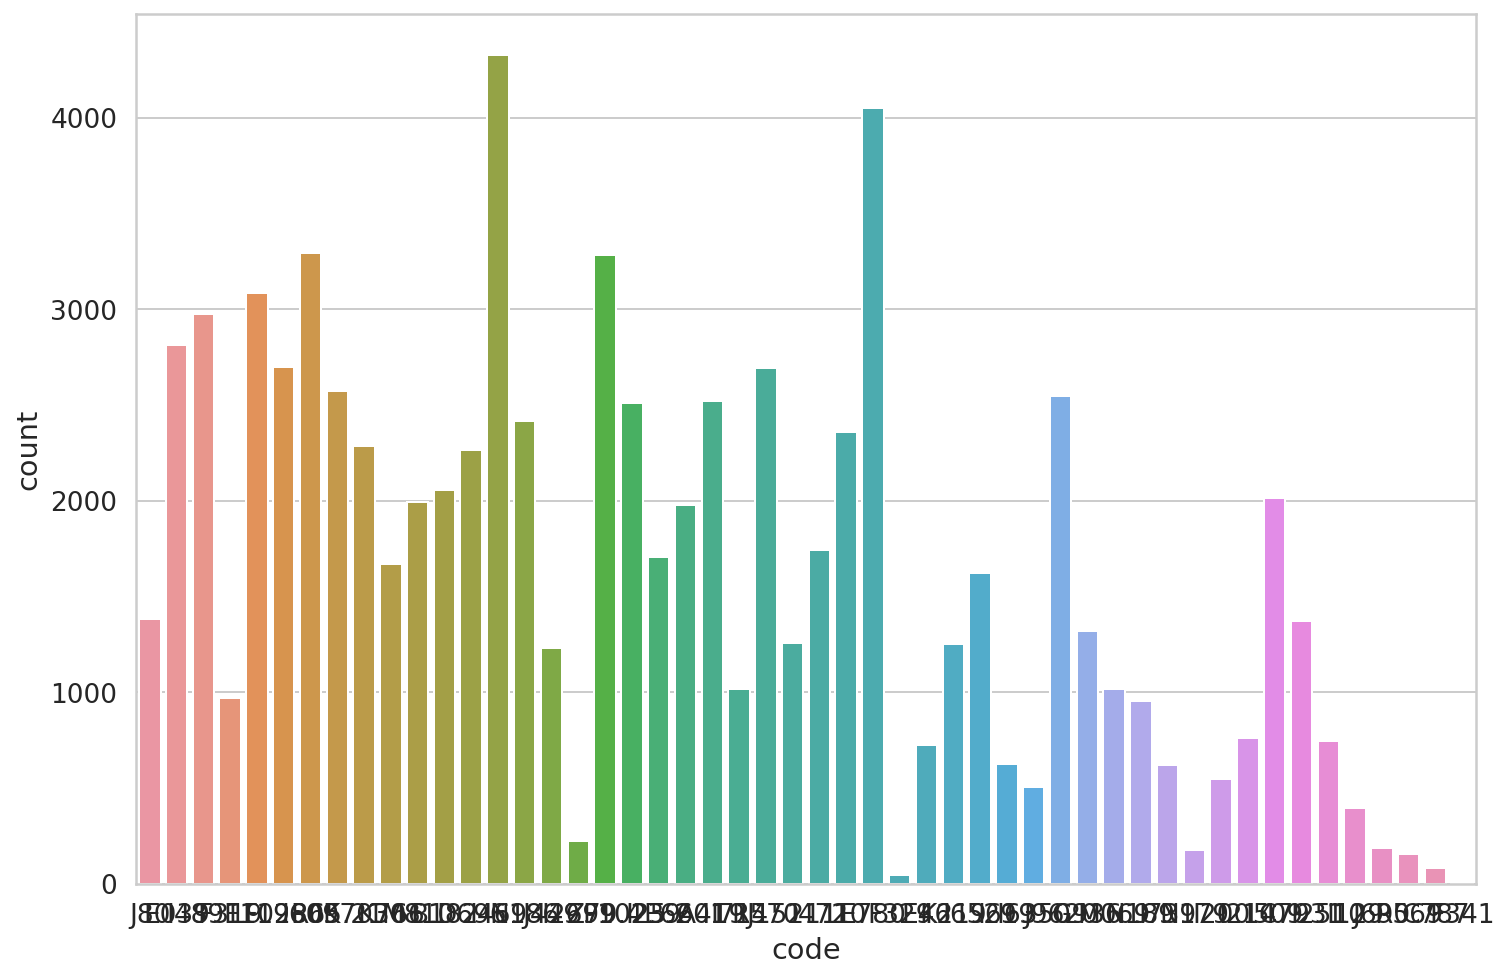

In [ ]:
sns.countplot(df.code)
plt.xlabel('code');

In [ ]:
print(df["code"].value_counts())

I469      4326
E780      4048
I609      3295
Z79.4     3284
E119      3084
I4891     2976
E039      2811
F0280     2698
R570      2695
R65.21    2575
J9620     2548
A419      2522
F10239    2512
N186      2417
I10       2358
K7030     2283
D696      2266
B182      2057
I509      2013
M810      1991
E6601     1975
I472      1741
I25.2     1705
K766      1670
I6529     1624
J80       1382
C7931     1369
G936      1321
J15211    1258
K219      1250
J449      1231
I714      1016
M069      1014
F319       968
N189       955
I214       758
I2510      746
E46        725
I619       626
I739       620
I200       545
I6350      503
I129       395
I2699      223
J690       186
N179       178
R569       153
C787        81
F329        44
F341         6
Name: code, dtype: int64


we have an imbalanced dataset





# **Data Preprocessing**

Converting categorical labels variable to number 

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df["code_labeled"]= encoder.fit_transform(df.code)

In [ ]:
df.head()

,sentence,code,code_labeled
0,pt transferred to [**hospital unit name 4**] c...,J80,36
1,chb d/t hypothyroidism--pt with recent hx of n...,E039,5
2,the patient is a 67-year-old female with a his...,I4891,25
3,"rca, htn, gerd, left knee replacement, bipolar...",F319,12
4,chronic obstructive pulmonary disease diabetes...,E119,6


In [ ]:
encoder.classes_

array(['A419', 'B182', 'C787', 'C7931', 'D696', 'E039', 'E119', 'E46',
       'E6601', 'E780', 'F0280', 'F10239', 'F319', 'F329', 'F341', 'G936',
       'I10', 'I129', 'I200', 'I214', 'I25.2', 'I2510', 'I2699', 'I469',
       'I472', 'I4891', 'I509', 'I609', 'I619', 'I6350', 'I6529', 'I714',
       'I739', 'J15211', 'J449', 'J690', 'J80', 'J9620', 'K219', 'K7030',
       'K766', 'M069', 'M810', 'N179', 'N186', 'N189', 'R569', 'R570',
       'R65.21', 'Z79.4'], dtype=object)

In [ ]:
class_name = df.code.unique().tolist()
print(len(class_name))
print(class_name)

50
['J80', 'E039', 'I4891', 'F319', 'E119', 'F0280', 'I609', 'R65.21', 'K7030', 'K766', 'M810', 'B182', 'D696', 'I469', 'N186', 'J449', 'I2699', 'Z79.4', 'F10239', 'I25.2', 'E6601', 'A419', 'I714', 'R570', 'J15211', 'I472', 'I10', 'E780', 'F329', 'E46', 'K219', 'I6529', 'I619', 'I6350', 'J9620', 'G936', 'M069', 'N189', 'I739', 'N179', 'I200', 'I214', 'I509', 'C7931', 'I2510', 'I129', 'J690', 'R569', 'C787', 'F341']


In [ ]:
df.shape 

(81027, 3)

In [ ]:
df = df.drop(columns = "code", axis = 0)  # dropping code column


In [ ]:
df.head()

,sentence,code_labeled
0,pt transferred to [**hospital unit name 4**] c...,36
1,chb d/t hypothyroidism--pt with recent hx of n...,5
2,the patient is a 67-year-old female with a his...,25
3,"rca, htn, gerd, left knee replacement, bipolar...",12
4,chronic obstructive pulmonary disease diabetes...,6


Let’s load a pre-trained AutoTokenizer:

>  





In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


In [ ]:
sample_txt = df.sentence[0]
sample_txt

'pt transferred to [**hospital unit name 4**] c/ respiratory distress [**9-6**]'

We’ll use this text to understand the tokenization process:

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: pt transferred to [**hospital unit name 4**] c/ respiratory distress [**9-6**]
   Tokens: ['p', '##t', 'transferred', 'to', '[', '*', '*', 'hospital', 'unit', 'name', '4', '*', '*', ']', 'c', '/', 'respiratory', 'distress', '[', '*', '*', '9', '-', '6', '*', '*', ']']
Token IDs: [185, 1204, 3175, 1106, 164, 115, 115, 2704, 2587, 1271, 125, 115, 115, 166, 172, 120, 19192, 13632, 164, 115, 115, 130, 118, 127, 115, 115, 166]


Some basic operations can convert the text to tokens and tokens to unique integers (ids):

**Special Tokens**

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id ,tokenizer.cls_token, tokenizer.cls_token_id,tokenizer.pad_token, tokenizer.pad_token_id

('[SEP]', 102, '[CLS]', 101, '[PAD]', 0)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  max_length=128,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape

torch.Size([1, 128])

The token ids are now stored in a Tensor and padded to a length of 128:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]


128


tensor([  101,   185,  1204,  3175,  1106,   164,   115,   115,  2704,  2587,
         1271,   125,   115,   115,   166,   172,   120, 19192, 13632,   164,
          115,   115,   130,   118,   127,   115,   115,   166,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

128


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'p',
 '##t',
 'transferred',
 'to',
 '[',
 '*',
 '*',
 'hospital',
 'unit',
 'name',
 '4',
 '*',
 '*',
 ']',
 'c',
 '/',
 'respiratory',
 'distress',
 '[',
 '*',
 '*',
 '9',
 '-',
 '6',
 '*',
 '*',
 ']',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PA

# **Create Pytorch Dataset and Dataloader**

We have all building blocks required to create a PyTorch dataset

In [ ]:
# reference link 
#https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Amazon%20Review%20Sentiment%20Analysis/amazon_reviews_sentiment_classification.ipynb
 

class CaseDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
       padding='max_length',
      return_attention_mask=True,
      truncation=True,
      
      return_tensors='pt')
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }



Splitting  the data:



In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2,stratify=df.code_labeled,random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((64821, 2), (8103, 2), (8103, 2))

We also need to create a couple of data loaders. Here’s a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CaseDataset(reviews=df.sentence.to_numpy(), targets=df.code_labeled.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
  return DataLoader( ds, batch_size=batch_size,num_workers=2)

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 128


train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


 Let’s load the model

In [ ]:

bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", return_dict = False)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'])

In [ ]:
last_hidden_state.shape

torch.Size([1, 128, 768])

We have the hidden state for each of our 128 tokens (the length of our example sequence). 768 is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768

You can think of the pooled_output as a summary of the content, according to BERT.  Let’s look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
bert_model.config.hidden_size

768

# **Model Creation**

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes = 50):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", return_dict = False)
    self.drop = nn.Dropout(p=0.3)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 100)
    self.relu1 = nn.ReLU()
    self.out = nn.Linear(100, 50)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu1(output)
    return self.out(output)

In [ ]:
model = SentimentClassifier()
model = model.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(model)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0160, 0.0181, 0.0209,  ..., 0.0196, 0.0257, 0.0189],
        [0.0180, 0.0147, 0.0187,  ..., 0.0170, 0.0241, 0.0235],
        [0.0191, 0.0158, 0.0175,  ..., 0.0177, 0.0341, 0.0212],
        ...,
        [0.0143, 0.0159, 0.0163,  ..., 0.0157, 0.0281, 0.0243],
        [0.0159, 0.0189, 0.0199,  ..., 0.0194, 0.0256, 0.0189],
        [0.0201, 0.0158, 0.0181,  ..., 0.0147, 0.0254, 0.0290]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

# **Training**

In [ ]:
# reference link 
#https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb



EPOCHS = 5

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

# **Train Loop**

In [ ]:
#refence link 
# https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb



def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
  history['epoch'].append(epoch+1)
  history['train_acc'].append(train_acc.item())
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss.item())

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
     

Epoch 1/5
----------
Train loss 0.7920871508001605 accuracy 0.840406658336033
Val   loss 0.3586953221490299 accuracy 0.9027520671356288

Epoch 2/5
----------
Train loss 0.32166232654745786 accuracy 0.9072522793539131
Val   loss 0.3150155297370525 accuracy 0.906084166358139

Epoch 3/5
----------
Train loss 0.25707360011684505 accuracy 0.9179432591289859
Val   loss 0.3079823622641366 accuracy 0.9042330001234111

Epoch 4/5
----------
Train loss 0.21059879813934443 accuracy 0.9283874053161784
Val   loss 0.3144882284214823 accuracy 0.9029988893002592

Epoch 5/5
----------
Train loss 0.17486760605044796 accuracy 0.9370420079912374
Val   loss 0.31703870318551347 accuracy 0.8997902011600643

CPU times: user 1h 44min 49s, sys: 46.1 s, total: 1h 45min 35s
Wall time: 1h 47min 19s


# **Evaluation**

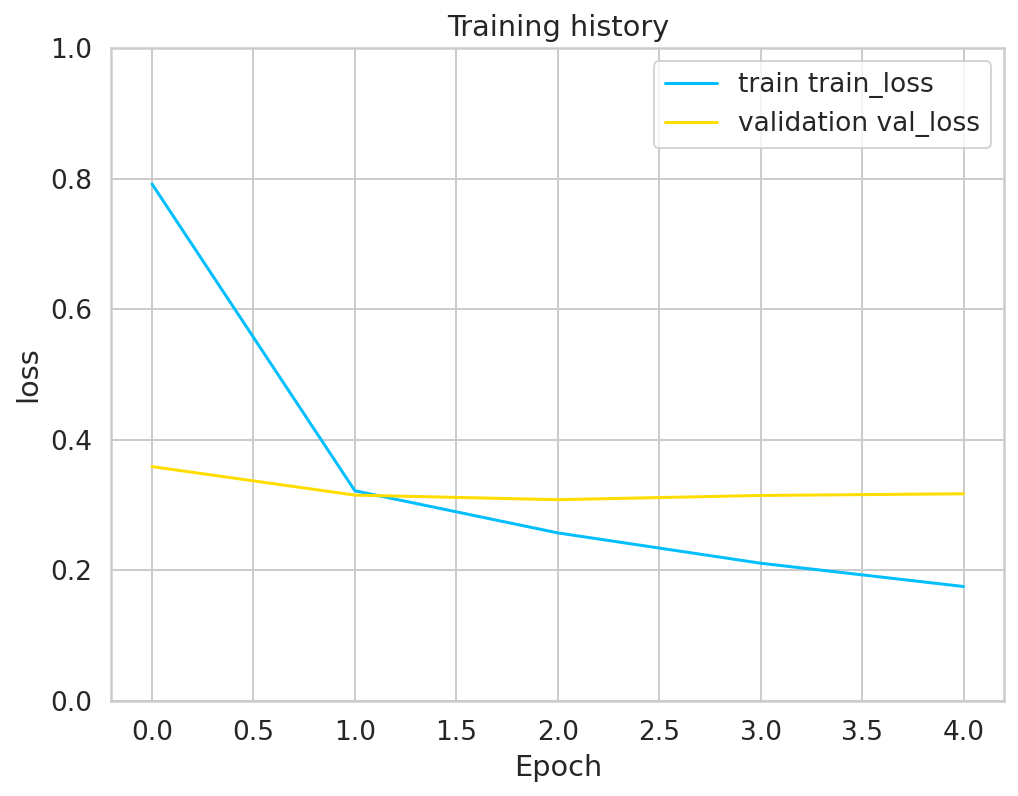

In [ ]:
rcParams['figure.figsize'] = 8, 6


plt.plot(history['train_loss'], label='train train_loss')
plt.plot(history['val_loss'], label='validation val_loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

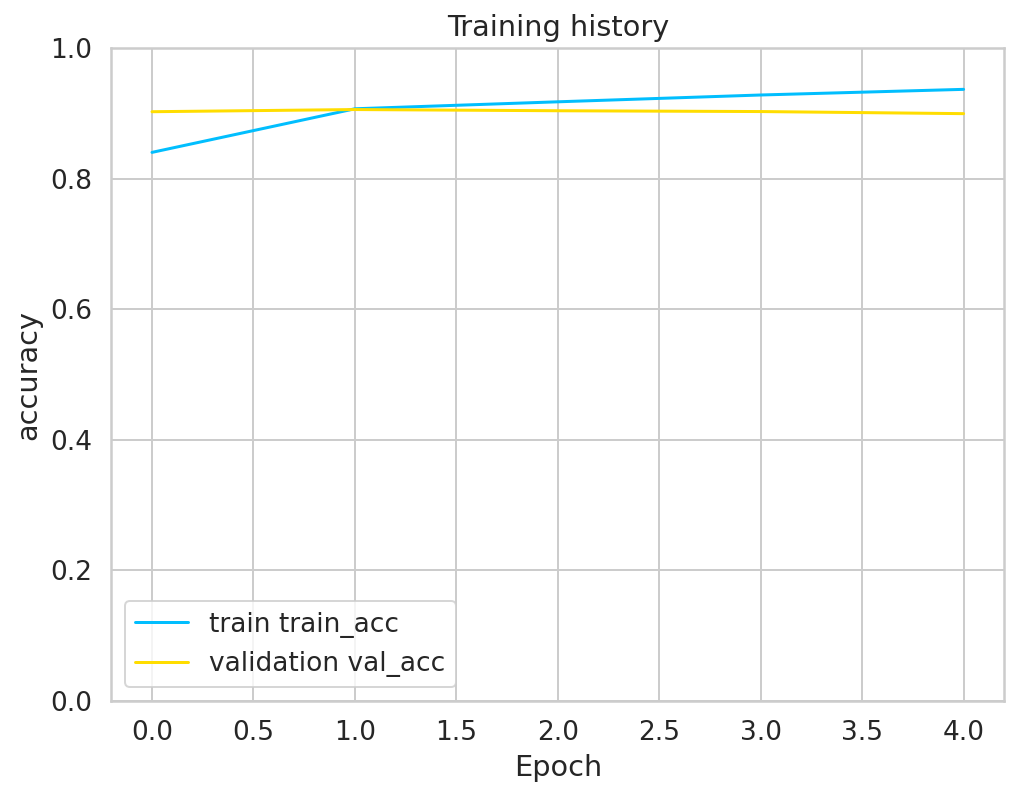

In [ ]:
rcParams['figure.figsize'] = 8, 6


plt.plot(history['train_acc'], label='train train_acc')
plt.plot(history['val_acc'], label='validation val_acc')

plt.title('Training history')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model( model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.9018881895594225

# **Prediction**

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
     

In [ ]:
print(classification_report(y_test, y_pred, target_names=encoder.classes_))
     

              precision    recall  f1-score   support

        A419       0.98      0.95      0.96       259
        B182       0.88      0.89      0.89       204
        C787       1.00      1.00      1.00        11
       C7931       0.98      0.98      0.98       124
        D696       0.93      0.96      0.94       225
        E039       0.84      0.81      0.82       274
        E119       0.68      0.76      0.71       321
         E46       0.91      0.96      0.93        70
       E6601       0.88      0.94      0.91       201
        E780       0.79      0.85      0.82       373
       F0280       0.95      0.94      0.94       285
      F10239       0.96      0.97      0.96       270
        F319       0.88      0.91      0.89        96
        F329       0.50      0.33      0.40         3
        F341       0.00      0.00      0.00         1
        G936       0.99      0.99      0.99       124
         I10       0.89      0.70      0.79       230
        I129       0.40    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Confusion Matrix**

In [ ]:
rcParams['figure.figsize'] = 15, 15

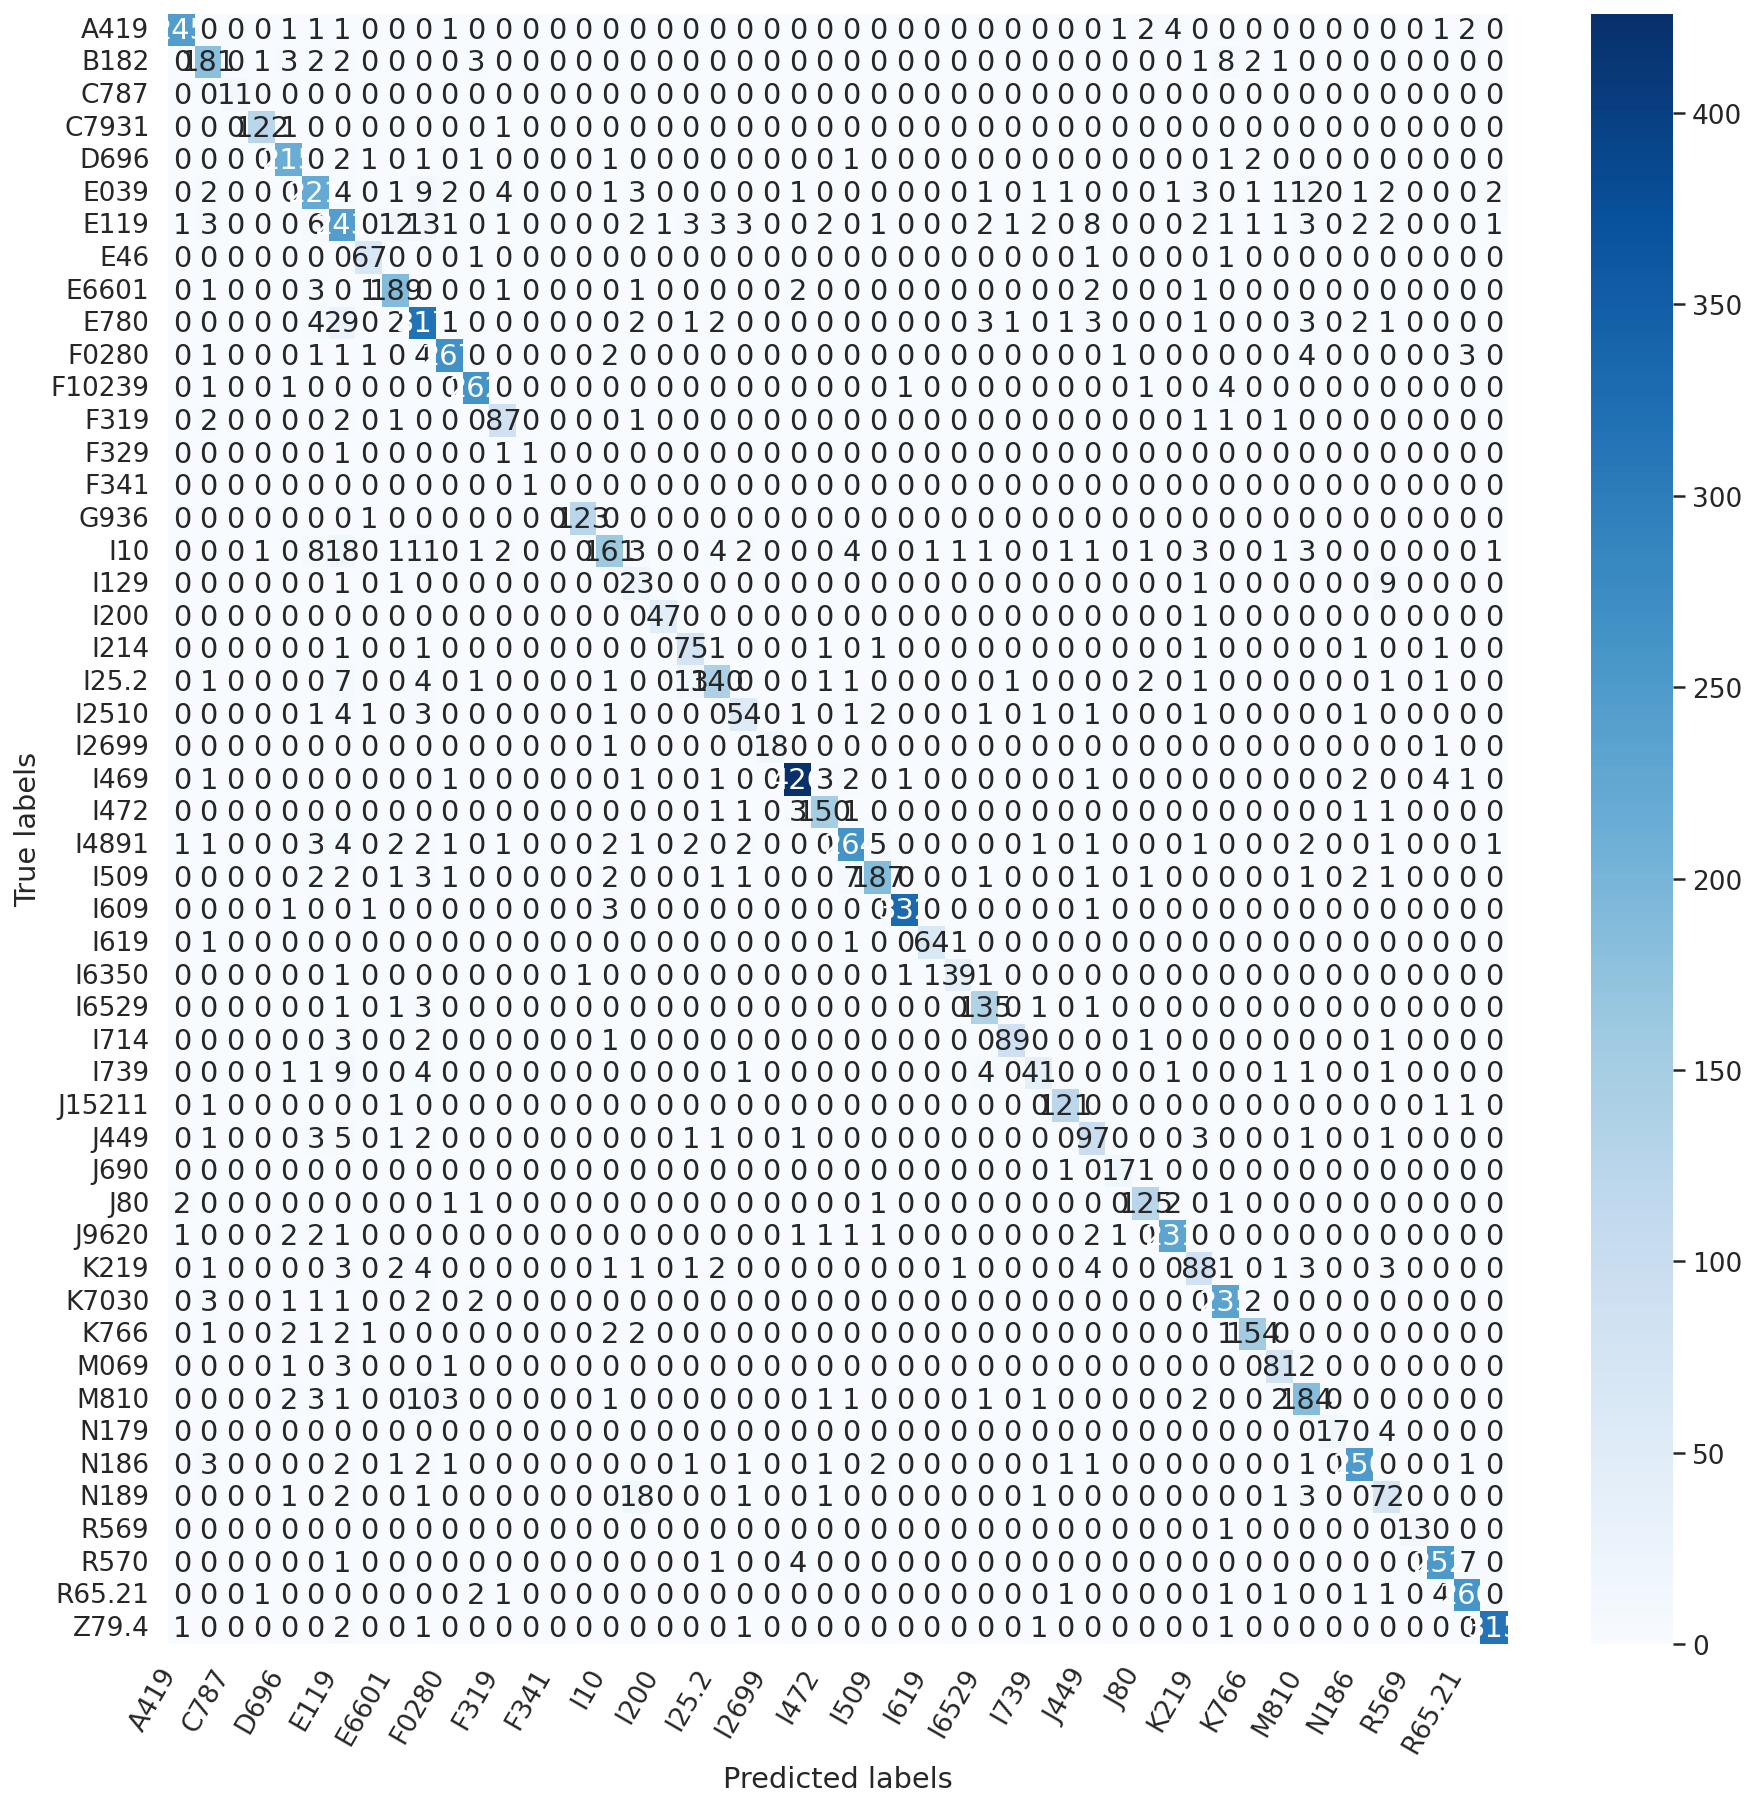

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=60, ha='right')
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)
show_confusion_matrix(df_cm)


In [ ]:
reloaded_model = torch.load("/content/best_model_state.bin")


In [ ]:
print(reloaded_model)